In [1]:
import pandas as pd
import numpy as np
import random 
import os
import glob
import matplotlib.pyplot as plt

random.seed(0)

In [2]:
drop_columns = [
    # Dataset Specific Information
    "Flow ID", 
    "Source IP", "Src IP", 
    "Source Port", "Src Port", 
    "Destination IP", "Dst IP",
    # Features Without Observed Variance
    "Bwd PSH Flags", 
    "Fwd URG Flags", 
    "Bwd URG Flags",
    "CWE Flag Count",
    "Fwd Avg Bytes/Bulk", "Fwd Byts/b Avg", 
    "Fwd Avg Packets/Bulk", "Fwd Pkts/b Avg", 
    "Fwd Avg Bulk Rate", "Fwd Blk Rate Avg",
    "Bwd Avg Bytes/Bulk", "Bwd Byts/b Avg", 
    "Bwd Avg Packets/Bulk", "Bwd Pkts/b Avg", 
    "Bwd Avg Bulk Rate", "Bwd Blk Rate Avg",
    # Duplicate Column
    'Fwd Header Length.1'
]

mapper = {
    'Dst Port': 'Destination Port',
    'Tot Fwd Pkts': 'Total Fwd Packets',
    'Tot Bwd Pkts': 'Total Backward Packets',
    'TotLen Fwd Pkts': 'Fwd Packets Length Total', 
    'Total Length of Fwd Packets': 'Fwd Packets Length Total',
    'TotLen Bwd Pkts': 'Bwd Packets Length Total',
    'Total Length of Bwd Packets': 'Bwd Packets Length Total', 
    'Fwd Pkt Len Max': 'Fwd Packet Length Max',
    'Fwd Pkt Len Min': 'Fwd Packet Length Min', 
    'Fwd Pkt Len Mean': 'Fwd Packet Length Mean', 
    'Fwd Pkt Len Std': 'Fwd Packet Length Std',
    'Bwd Pkt Len Max': 'Bwd Packet Length Max', 
    'Bwd Pkt Len Min': 'Bwd Packet Length Min', 
    'Bwd Pkt Len Mean': 'Bwd Packet Length Mean',
    'Bwd Pkt Len Std': 'Bwd Packet Length Std', 
    'Flow Byts/s': 'Flow Bytes/s', 
    'Flow Pkts/s': 'Flow Packets/s', 
    'Fwd IAT Tot': 'Fwd IAT Total',
    'Bwd IAT Tot': 'Bwd IAT Total', 
    'Fwd Header Len': 'Fwd Header Length', 
    'Bwd Header Len': 'Bwd Header Length', 
    'Fwd Pkts/s': 'Fwd Packets/s',
    'Bwd Pkts/s': 'Bwd Packets/s', 
    'Pkt Len Min': 'Packet Length Min', 
    'Min Packet Length': 'Packet Length Min',
    'Pkt Len Max': 'Packet Length Max', 
    'Max Packet Length': 'Packet Length Max',
    'Pkt Len Mean': 'Packet Length Mean',
    'Pkt Len Std': 'Packet Length Std', 
    'Pkt Len Var': 'Packet Length Variance', 
    'FIN Flag Cnt': 'FIN Flag Count', 
    'SYN Flag Cnt': 'SYN Flag Count',
    'RST Flag Cnt': 'RST Flag Count', 
    'PSH Flag Cnt': 'PSH Flag Count', 
    'ACK Flag Cnt': 'ACK Flag Count', 
    'URG Flag Cnt': 'URG Flag Count',
    'ECE Flag Cnt': 'ECE Flag Count', 
    'Pkt Size Avg': 'Avg Packet Size',
    'Average Packet Size': 'Avg Packet Size',
    'Fwd Seg Size Avg': 'Avg Fwd Segment Size',
    'Bwd Seg Size Avg': 'Avg Bwd Segment Size', 
    'Fwd Byts/b Avg': 'Fwd Avg Bytes/Bulk',
    'Fwd Pkts/b Avg': 'Fwd Avg Packets/Bulk', 
    'Fwd Blk Rate Avg': 'Fwd Avg Bulk Rate', 
    'Bwd Byts/b Avg': 'Bwd Avg Bytes/Bulk',
    'Bwd Pkts/b Avg': 'Bwd Avg Packets/Bulk', 
    'Bwd Blk Rate Avg': 'Bwd Avg Bulk Rate', 
    'Subflow Fwd Pkts': 'Subflow Fwd Packets',
    'Subflow Fwd Byts': 'Subflow Fwd Bytes', 
    'Subflow Bwd Pkts': 'Subflow Bwd Packets', 
    'Subflow Bwd Byts': 'Subflow Bwd Bytes',
    'Init Fwd Win Byts': 'Init Fwd Win Bytes', 
    'Init_Win_bytes_forward': 'Init Fwd Win Bytes',
    'Init Bwd Win Byts': 'Init Bwd Win Bytes', 
    'Init_Win_bytes_backward': 'Init Bwd Win Bytes',
    'Fwd Act Data Pkts': 'Fwd Act Data Packets',
    'act_data_pkt_fwd': 'Fwd Act Data Packets',
    'Fwd Seg Size Min': 'Fwd Seg Size Min',
    'min_seg_size_forward': 'Fwd Seg Size Min'
}

In [3]:
def plot_day(df):
    df.loc[df["Label"] == "Benign", 'Timestamp'].plot(style='.', color="lightgreen", label='Benign')
    for label in df.Label.unique():
        if label != 'Benign':
            df.loc[df["Label"] == label, 'Timestamp'].plot(style='.', label=label)
    plt.legend()
    plt.show()

In [4]:
def clean_dataset(dataset, filetypes=['feather']):
    # Will search for all files in the dataset subdirectory 'orignal'
    for file in os.listdir(f'{dataset}/original'):
        print(f"------- {file} -------")
        df = pd.read_csv(f"{dataset}/original/{file}", skipinitialspace=True, encoding='latin')
        print(df["Label"].value_counts())
        print(f"Shape: {df.shape}")

        # Rename column names for uniform column names across files
        df.rename(columns=mapper, inplace=True)

        # Drop unrelevant columns
        df.drop(columns=drop_columns, inplace=True, errors="ignore")

        # Parse Timestamp column to pandas datetime
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
        df['Timestamp'] = df['Timestamp'].apply(lambda x: x + pd.Timedelta(hours=12) if x.hour < 8 else x)
        df = df.sort_values(by=['Timestamp'])

        # Make Label column Categorical
        df['Label'].replace({'BENIGN': 'Benign'}, inplace=True)
        df['Label'] = df.Label.astype('category')

        # Parse Columns to correct dtype
        int_col = df.select_dtypes(include='integer').columns
        df[int_col] = df[int_col].apply(pd.to_numeric, errors='coerce', downcast='integer')
        float_col = df.select_dtypes(include='float').columns
        df[float_col] = df[float_col].apply(pd.to_numeric, errors='coerce', downcast='float')
        obj_col = df.select_dtypes(include='object').columns
        print(f'Columns with dtype == object: {obj_col}')
        df[obj_col] = df[obj_col].apply(pd.to_numeric, errors='coerce')

        # Drop rows with invalid data
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        print(f"{df.isna().any(axis=1).sum()} invalid rows dropped")
        df.dropna(inplace=True)

        # Drop duplicate rows
        df.drop_duplicates(inplace=True, subset=df.columns.difference(['Label', 'Timestamp']))
        print(df["Label"].value_counts())
        print(f"shape: {df.shape}\n")

        # Reset index
        df.reset_index(inplace=True, drop=True)

        # Plot resulting file
        plot_day(df)

        # Save to file
        if 'feather' in filetypes:
            df.to_feather(f'{dataset}/clean/{file}.feather')
        if 'parquet' in filetypes:
            df.to_parquet(f'{dataset}/clean/{file}.parquet', index=False)

In [ ]:
def aggregate_data(dataset, save=True, filetype='feather'):
    # Will search for all files in the 'clean' directory of the correct filetype and aggregate them
    all_data = pd.DataFrame()
    for file in glob.glob(f'{dataset}/clean/*.{filetype}'):
        print(file)
        df = pd.DataFrame()
        if filetype == 'feather':
            df = pd.read_feather(file)
        if filetype == 'parquet':
            df = pd.read_parquet(file)
        print(df.shape)
        print(f'{df["Label"].value_counts()}\n')
        all_data = pd.concat([all_data, df], ignore_index=True)
    print('ALL DATA')
    duplicates = all_data[all_data.duplicated(subset=all_data.columns.difference(['Label', 'Timestamp']))]
    print('Removed duplicates after aggregating:')
    print(duplicates.Label.value_counts())
    print('Resulting Dataset')
    all_data.drop(duplicates.index, axis=0, inplace=True)
    all_data.reset_index(inplace=True, drop=True)
    print(all_data.shape)
    print(f'{all_data["Label"].value_counts()}\n')
    if save:
        malicious = all_data[all_data.Label != 'Benign'].reset_index(drop = True)
        benign = all_data[all_data.Label == 'Benign'].reset_index(drop = True)
        if filetype == 'feather':
            all_data.to_feather(f'{dataset}/clean/all_data.feather')
            malicious.to_feather(f'{dataset}/clean/all_malicious.feather')
            benign.to_feather(f'{dataset}/clean/all_benign.feather')
        if filetype == 'parquet':
            all_data.to_parquet(f'{dataset}/clean/all_data.parquet', index=False)
            malicious.to_parquet(f'{dataset}/clean/all_malicious.parquet', index=False)
            benign.to_parquet(f'{dataset}/clean/all_benign.parquet', index=False)

------- Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv -------
DDoS      128027
BENIGN     97718
Name: Label, dtype: int64
Shape: (225745, 85)
Columns with dtype == object: Index([], dtype='object')
34 invalid rows dropped
DDoS      128014
Benign     95068
Name: Label, dtype: int64
shape: (223082, 70)



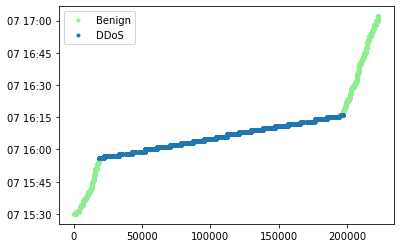

------- Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv -------
PortScan    158930
BENIGN      127537
Name: Label, dtype: int64
Shape: (286467, 85)
Columns with dtype == object: Index([], dtype='object')
371 invalid rows dropped
Benign      123083
PortScan     90694
Name: Label, dtype: int64
shape: (213777, 70)



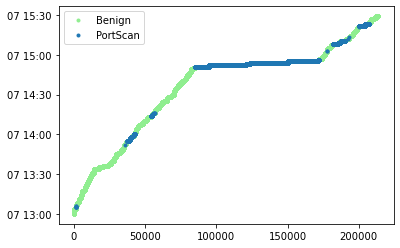

------- Friday-WorkingHours-Morning.pcap_ISCX.csv -------
BENIGN    189067
Bot         1966
Name: Label, dtype: int64
Shape: (191033, 85)
Columns with dtype == object: Index([], dtype='object')
122 invalid rows dropped
Benign    182096
Bot         1948
Name: Label, dtype: int64
shape: (184044, 70)



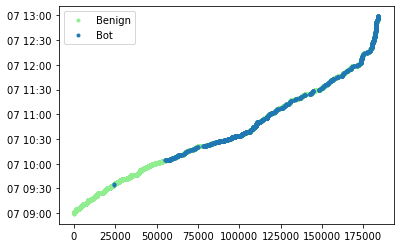

------- Monday-WorkingHours.pcap_ISCX.csv -------
BENIGN    529918
Name: Label, dtype: int64
Shape: (529918, 85)
Columns with dtype == object: Index([], dtype='object')
437 invalid rows dropped
Benign    502650
Name: Label, dtype: int64
shape: (502650, 70)



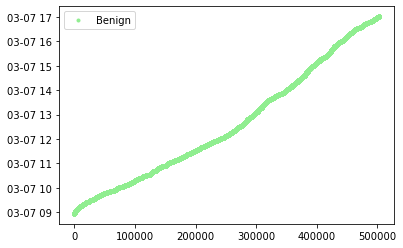

------- Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv -------
BENIGN          288566
Infiltration        36
Name: Label, dtype: int64
Shape: (288602, 85)
Columns with dtype == object: Index([], dtype='object')
207 invalid rows dropped
Benign          252754
Infiltration        36
Name: Label, dtype: int64
shape: (252790, 70)



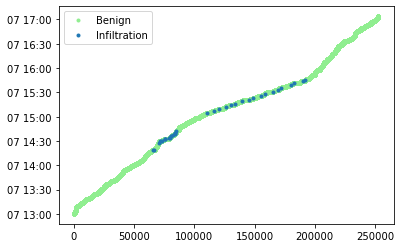

------- Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv -------


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (0,1,3,6,84) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


BENIGN                        168186
Web Attack  Brute Force        1507
Web Attack  XSS                 652
Web Attack  Sql Injection        21
Name: Label, dtype: int64
Shape: (458968, 85)
Columns with dtype == object: Index([], dtype='object')
288737 invalid rows dropped
Benign                        162010
Web Attack  Brute Force        1470
Web Attack  XSS                 652
Web Attack  Sql Injection        21
Name: Label, dtype: int64
shape: (164153, 70)



/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


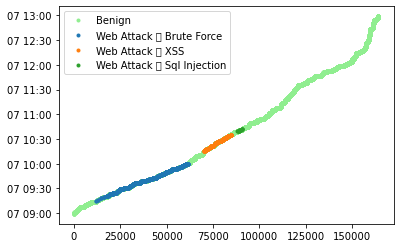

------- Tuesday-WorkingHours.pcap_ISCX.csv -------
BENIGN         432074
FTP-Patator      7938
SSH-Patator      5897
Name: Label, dtype: int64
Shape: (445909, 85)
Columns with dtype == object: Index([], dtype='object')
264 invalid rows dropped
Benign         412476
FTP-Patator      5931
SSH-Patator      3219
Name: Label, dtype: int64
shape: (421626, 70)



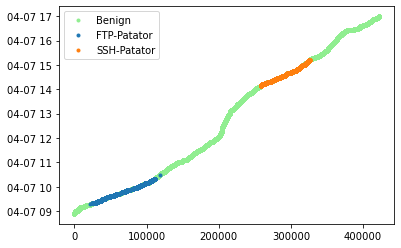

------- Wednesday-workingHours.pcap_ISCX.csv -------
BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: Label, dtype: int64
Shape: (692703, 85)
Columns with dtype == object: Index([], dtype='object')
1297 invalid rows dropped
Benign              416694
DoS Hulk            172841
DoS GoldenEye        10286
DoS slowloris         5385
DoS Slowhttptest      5228
Heartbleed              11
Name: Label, dtype: int64
shape: (610445, 70)



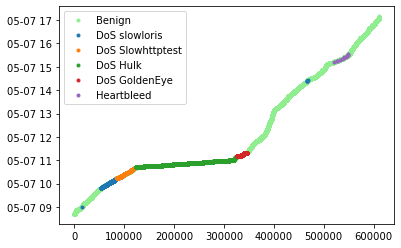

In [ ]:
# Needs directory with dataset name containing empty dir 'clean' and dir 'original' containing de csv's
clean_dataset('data/2017', filetypes=['feather', 'parquet'])

In [ ]:
aggregate_data('data/2017', save=True, filetype='feather')
aggregate_data('data/2017', save=True, filetype='parquet')

cicids2017/clean/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv.feather
(223082, 70)
DDoS      128014
Benign     95068
Name: Label, dtype: int64

cicids2017/clean/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv.feather
(213777, 70)
Benign      123083
PortScan     90694
Name: Label, dtype: int64

cicids2017/clean/Friday-WorkingHours-Morning.pcap_ISCX.csv.feather
(184044, 70)
Benign    182096
Bot         1948
Name: Label, dtype: int64

cicids2017/clean/Monday-WorkingHours.pcap_ISCX.csv.feather
(502650, 70)
Benign    502650
Name: Label, dtype: int64

cicids2017/clean/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv.feather
(252790, 70)
Benign          252754
Infiltration        36
Name: Label, dtype: int64

cicids2017/clean/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.feather
(164153, 70)
Benign                        162010
Web Attack  Brute Force        1470
Web Attack  XSS                 652
Web Attack  Sql Injection        21
Name: Label, dtype: int64



------- Friday-02-03-2018_TrafficForML_CICFlowMeter.csv -------
Benign    762384
Bot       286191
Name: Label, dtype: int64
Shape: (1048575, 80)
Columns with dtype == object: Index([], dtype='object')
4050 invalid rows dropped
Benign    675369
Bot       144535
Name: Label, dtype: int64
shape: (819904, 70)



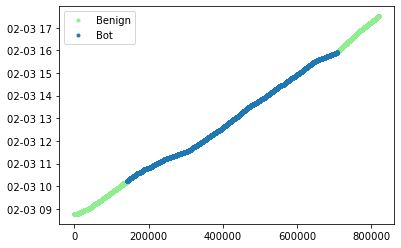

------- Friday-16-02-2018_TrafficForML_CICFlowMeter.csv -------


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Label                            1
Name: Label, dtype: int64
Shape: (1048575, 80)
Columns with dtype == object: Index(['Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s

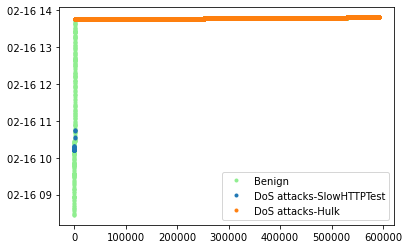

------- Friday-23-02-2018_TrafficForML_CICFlowMeter.csv -------
Benign              1048009
Brute Force -Web        362
Brute Force -XSS        151
SQL Injection            53
Name: Label, dtype: int64
Shape: (1048575, 80)
Columns with dtype == object: Index([], dtype='object')
5708 invalid rows dropped
Benign              904640
Brute Force -Web       339
Brute Force -XSS       150
SQL Injection           48
Name: Label, dtype: int64
shape: (905177, 70)



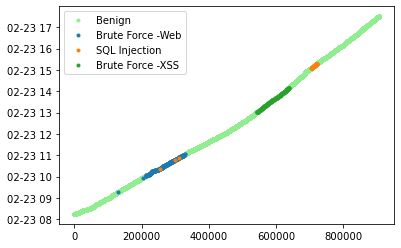

------- Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv -------
Benign                    7372557
DDoS attacks-LOIC-HTTP     576191
Name: Label, dtype: int64
Shape: (7948748, 84)
Columns with dtype == object: Index([], dtype='object')
59453 invalid rows dropped
Benign                    5498131
DDoS attacks-LOIC-HTTP     575364
Name: Label, dtype: int64
shape: (6073495, 70)



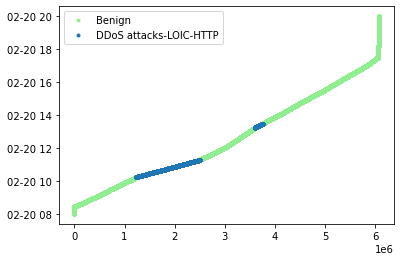

------- Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv -------


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Benign           238037
Infilteration     93063
Label                25
Name: Label, dtype: int64
Shape: (331125, 80)
Columns with dtype == object: Index(['Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Me

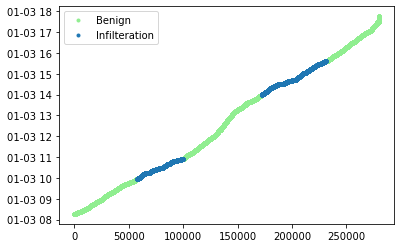

------- Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv -------
Benign                   996077
DoS attacks-GoldenEye     41508
DoS attacks-Slowloris     10990
Name: Label, dtype: int64
Shape: (1048575, 80)
Columns with dtype == object: Index([], dtype='object')
8027 invalid rows dropped
Benign                   825632
DoS attacks-GoldenEye     41406
DoS attacks-Slowloris      9908
Name: Label, dtype: int64
shape: (876946, 70)



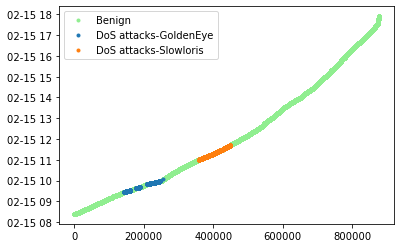

------- Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv -------
Benign              1048213
Brute Force -Web        249
Brute Force -XSS         79
SQL Injection            34
Name: Label, dtype: int64
Shape: (1048575, 80)
Columns with dtype == object: Index([], dtype='object')
5610 invalid rows dropped
Benign              901219
Brute Force -Web       228
Brute Force -XSS        79
SQL Injection           31
Name: Label, dtype: int64
shape: (901557, 70)



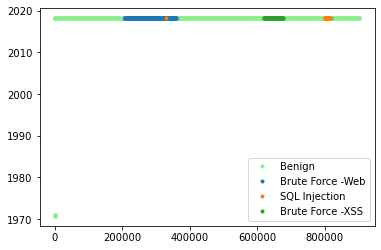

------- Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv -------
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64
Shape: (1048575, 80)
Columns with dtype == object: Index([], dtype='object')
3824 invalid rows dropped
Benign            577037
SSH-Bruteforce     94041
FTP-BruteForce        53
Name: Label, dtype: int64
shape: (671131, 70)



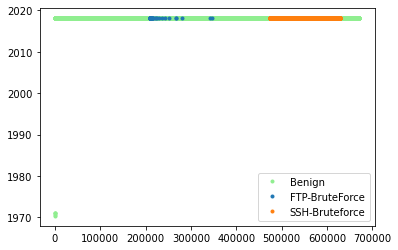

------- Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv -------
DDOS attack-HOIC        686012
Benign                  360833
DDOS attack-LOIC-UDP      1730
Name: Label, dtype: int64
Shape: (1048575, 80)
Columns with dtype == object: Index([], dtype='object')
0 invalid rows dropped
Benign                  360814
DDOS attack-HOIC        198861
DDOS attack-LOIC-UDP      1730
Name: Label, dtype: int64
shape: (561405, 70)



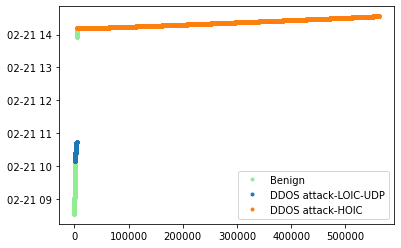

------- Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv -------


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Benign           544200
Infilteration     68871
Label                33
Name: Label, dtype: int64
Shape: (613104, 80)
Columns with dtype == object: Index(['Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Me

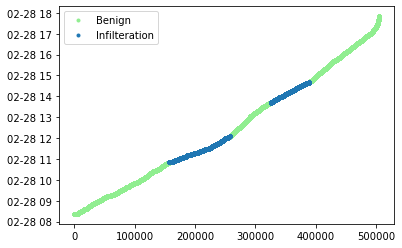

In [ ]:
clean_dataset('data/2018', filetypes=['feather', 'parquet'])

In [ ]:
aggregate_data('data/2018', save=True, filetype='feather')
aggregate_data('data/2018', save=True, filetype='parquet')

cicids2018/clean/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv.feather
(819904, 70)
Benign    675369
Bot       144535
Name: Label, dtype: int64

cicids2018/clean/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv.feather
(591901, 70)
Benign                      446647
DoS attacks-Hulk            145199
DoS attacks-SlowHTTPTest        55
Label                            0
Name: Label, dtype: int64

cicids2018/clean/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv.feather
(905177, 70)
Benign              904640
Brute Force -Web       339
Brute Force -XSS       150
SQL Injection           48
Name: Label, dtype: int64

cicids2018/clean/Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv.feather
(6073495, 70)
Benign                    5498131
DDoS attacks-LOIC-HTTP     575364
Name: Label, dtype: int64

cicids2018/clean/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv.feather
(279818, 70)
Benign           202357
Infilteration     77461
Label                 0
Name: Label, dtype: int64

cicids20